In [1]:
from ultralytics import YOLO, settings
import os
import shutil
from IPython.display import display, Image
from IPython import display
import cv2
import matplotlib.pyplot as plt
import numpy as np
display.clear_output()

# CONSTANTS
IMG_PATH_RANDOM = '../images/classification/random'
MODEL_PATH_OBB = '../models/yolov8n_obb_100epochs.pt'
SAVE_DIR_RANDOM = '../images/cropped_scales/random'
RUNS_DIR = settings['runs_dir']
OBB_PREDICT_PATH = os.path.join(RUNS_DIR, 'obb\\predict')

if not os.path.exists(SAVE_DIR_RANDOM):
    os.makedirs(SAVE_DIR_RANDOM)

In [2]:
def crop_scale_random(images: list):
    model_obb = YOLO(MODEL_PATH_OBB)
    # remove old runs
    shutil.rmtree(os.path.join(RUNS_DIR, 'obb'), ignore_errors=True)
    # predict images
    results_fixed = model_obb(images, conf=0.8)
    return results_fixed


def load_image(image_path, fig_size=(50, 50), grid=False, x_ticks=30, y_ticks=10, x_rotation=0, y_rotation=0, save=False, save_path=None):
    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB (matplotlib uses RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create a figure with a specific size
    plt.figure(figsize=fig_size)

    # Show the image
    plt.imshow(image_rgb)

    if grid:
        # Add grid lines to the image for easier measurement
        plt.grid(color='r', linestyle='-', linewidth=0.5)

        # Optionally, you can customize the ticks to match your image's scale
        plt.xticks(range(0, image_rgb.shape[1], x_ticks), rotation=x_rotation)  # Adjust the spacing as needed
        plt.yticks(range(0, image_rgb.shape[0], y_ticks), rotation=y_rotation)  # Adjust the spacing as needed

    if save:
        if save_path is None:
            plt.savefig(image_path.split('/')[-1], bbox_inches='tight', transparent=True)
            plt.close()
        else:
            plt.savefig(save_path, bbox_inches='tight', transparent=True)
            plt.close()

In [53]:
all_images = os.listdir(IMG_PATH_RANDOM)
images = [os.path.join(IMG_PATH_RANDOM, img) for img in all_images]

results = crop_scale_random(images)


0: 640x640 38.1ms
1: 640x640 38.1ms
2: 640x640 38.1ms
3: 640x640 38.1ms
4: 640x640 38.1ms
5: 640x640 38.1ms
6: 640x640 38.1ms
7: 640x640 38.1ms
8: 640x640 38.1ms
9: 640x640 38.1ms
10: 640x640 38.1ms
11: 640x640 38.1ms
12: 640x640 38.1ms
Speed: 2.9ms preprocess, 38.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


In [54]:
for result in results:
    image_path = result.path
    image_name = image_path.split('\\')[-1]
    bbox = result.obb.xyxyxyxy[0].tolist()

    # Load the image
    image = cv2.imread(image_path)

    # Define the quadrilateral
    quadrilateral = np.array(result.obb.xyxyxyxy[0])

    # Compute axis aligned bounding box of the quadrilateral
    x, y, w, h = cv2.boundingRect(quadrilateral)

    # Crop the image
    cropped_image = image[y:y + h, x:x + w]

    # Save the result
    cv2.imwrite(os.path.join(SAVE_DIR_RANDOM, image_name.replace('.jpg', '_scale_only.jpg')), cropped_image)

    # Move original image
    shutil.move(image_path, os.path.join(SAVE_DIR_RANDOM, image_name))

# Remove old directory
shutil.rmtree(OBB_PREDICT_PATH, ignore_errors=True)
shutil.rmtree(IMG_PATH_RANDOM, ignore_errors=True)

2nd approach

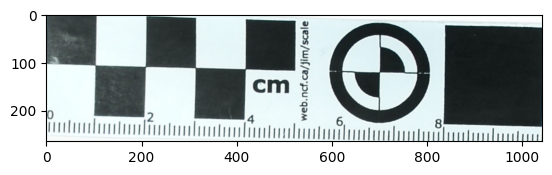

In [83]:
x, y, w, h, r = results[0].obb.xywhr[0].tolist()

image = cv2.imread(os.path.join(SAVE_DIR_RANDOM, results[0].path.split('\\')[-1]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def rotate_image(image, angle, center):
    (h,w) = image.shape[:2]
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w,h))
    return rotated

# Rotate the image to correct for the ROI's rotation
rotated_image = rotate_image(image, -np.degrees(r), (int(x), int(y)))

center_x, center_y = int(x), int(y)
width, height = int(w), int(h)

x1_rotated = center_x - width // 2
y1_rotated = center_y - height // 2

# Crop the rotated image
cropped_rotated_image = rotated_image[y1_rotated:y1_rotated + height, x1_rotated:x1_rotated + width]

# Display the cropped, rotated image
plt.imshow(cv2.cvtColor(cropped_rotated_image, cv2.COLOR_BGR2RGB))
plt.show()